2D PSF models for 3D reconstructions
------------------------------------

### General outline

The idea is to create/package the required functions to load/save PSF models and extract dictionaries from them. This code should export two series of PSF:

- The first one extracted from lattice light sheet acquisitions
- The second one from the epifluorescence microscope

As a second step, 3D reconstructions should be performed using the sliding windows model. The next step is then to perform patch extraction (with a cluster-compatible code)

This notebook should mimic the steps described in `51.2D PSF models`. A cluster-ready version is available on `54.Lattice -- SLURM`. This script should clearly recapitulate how to generate Figure 3.

### More precisely

The first parts show how to generate the figure on a desktop computer, and the rest of the code generate the required scripts to be run on a computing cluster.

The analyses to be performes are as follow:

1. Show sample reconstructions for various planes
2. Choose a plane and play with the compression ratio
3. Extract a line profile of a given PSF
4. Compute MSE and SSIM of the reconstructed images at increasing compression ratios

All this analyses are performed in a following notebook: `3b.Lattice light sheet beads (analysis)`

In [1]:
%matplotlib inline
import sys, os
import scipy.linalg
import numpy as np
from libtiff import TIFF
import matplotlib.pyplot as plt
sys.path.append("../../3_code/")
import cstools
reload(cstools)

# useful function
def spiral(m, b):
    """Poisson likelihood objective function"""
    return cstools.reconstruct_1Dspiral(m, b, maxiter=1000, noisetype='poisson')
def spiral2(m, b):
    """Gaussian likelihood objective function"""
    return cstools.reconstruct_1Dspiral(m, b, maxiter=2000)
def spiral_tv(m, b): 
    """Total variation reconstruction"""
    return cstools.reconstruct_1Dspiral(m, b, maxiter=2000, penalty='tv')

bn = "../../4_data/lattice-lightsheet/161013_cstest/"
eye_p = os.path.join(bn, "eyefullfov20um.tif")
fou_p = os.path.join(bn, "fourierfullfov20um.tif")

# Load matrices
fou = cstools.read_tif(fou_p, div2=True)
eye = cstools.read_tif(eye_p, div2=True)

# PSF extraction and saving

Loaded PSF from file ../../5_outputs/psf_models/lattice_161114.npy
Not saving the PSF
(101, 5928) (404, 1482)


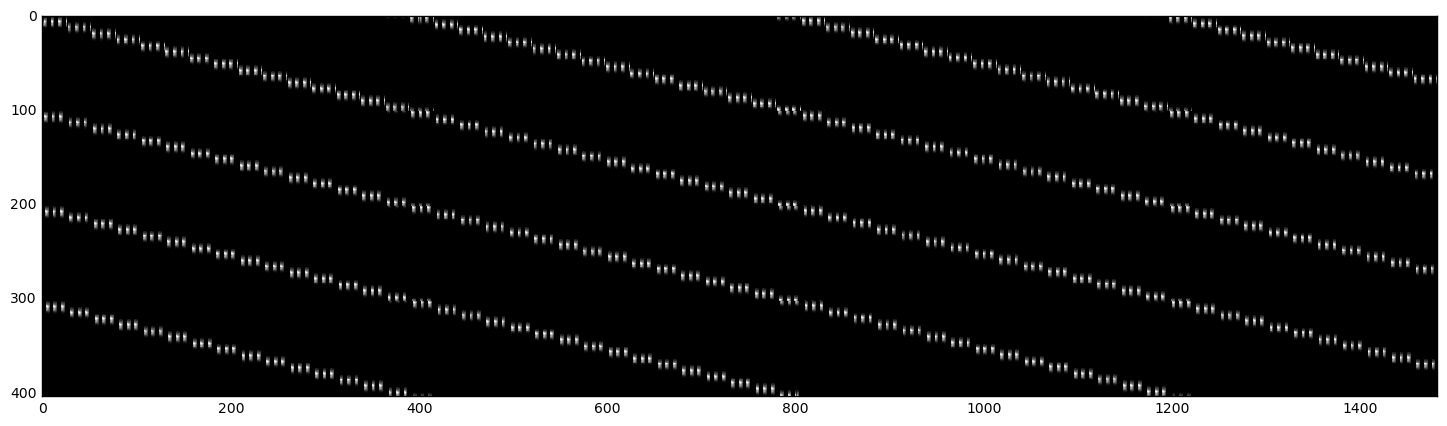

In [31]:
## 1. Extract a PSF
psfz_ok = True # Flag to switch between calibration and generation of the PSF
psfx_ok = True
save_psf = "../../5_outputs/psf_models/lattice_161114" ## Set to None to avoid saving
load_psf = True ## Load the PSF from the save_psf file.

step = 8 ## A fraction of the size of the PSF in z. Represent the shift in the final dictionary.
psf_x = 205
psf_y = range(363, 367)
psf_z = (82, 95)

if load_psf:
    psf=np.load(save_psf+".npy")
    print "Loaded PSF from file {}.npy".format(save_psf)
else:
    psf = eye.mean(0)[psf_y,psf_z[0]:psf_z[-1]].T
    psf -= psf.min()

if save_psf != None and not load_psf and not os.path.isfile(save_psf): ## Save the PSF if needed
    np.save(save_psf, psf)
    print "PSF saved on file {}".format(save_psf)
elif not load_psf and save_psf != None and os.path.isfile(save_psf):
    raise IOError("File {} exists".format(save_psf))
else:
    print "Not saving the PSF"

if not psfz_ok:
    plt.imshow(psf, cmap='gray', interpolation="none")
elif not psfx_ok:
    psf_xutil = psf.mean(1)
    plt.plot(psf_xutil)
else:
    l=np.zeros((eye.shape[2], 2*psf.shape[1]))
    l[:psf.shape[0],:psf.shape[1]]=psf
    ll=[]
    for j in range(step*int(eye.shape[2]/psf.shape[0])+1):
        for k in range(2*psf.shape[0]):
            ll.append(np.roll(np.roll(l, psf.shape[0]*psf.shape[1]*j/step, axis=0), k, axis=1)[:,int(l.shape[1]/2):int(l.shape[1]*3./2)])
    
    D1 = np.hstack(ll) ## This is the dictionary.
    D2 = np.hstack([i.T.reshape((-1,1)) for i in ll])
    
    print D1.shape, D2.shape
    plt.figure(figsize=(18,5))
    plt.imshow(D2, cmap='gray', interpolation="none")

# Reconstruction (lattice)

In [33]:
## Generate measurement matrix
b=cstools.generate_fourier_basis(101, 50+1, sample=False, oldmethod=True)
B = cstools.build_2dmodel(b, psf.mean(0)).dot(D2)

## Apply the 2D model
def reco_image(ima, verbose=True, tv=False):
    rr = np.arange(0, eye[0, :,:].shape[0], psf.shape[1])
    im = []
    for (i,j) in enumerate(zip(rr[:-1],rr[1:])):
        if verbose and i%20 == 0:
            print "{}/{}".format(i, len(rr))
        (sta,sto) = j
        #im_sub = fou[ima, range(sta,sto),:].flatten()
        im_sub = ima[range(sta,sto),:].flatten()
        if tv:
            r_sim = spiral_tv(im_sub, B).dot(D2.T).reshape((psf.shape[1], -1))
        else:
            r_sim = spiral2(im_sub, B).dot(D2.T).reshape((psf.shape[1], -1))
        im.append(r_sim)
    im = np.vstack(im).T
    return im

## Apply the 2D model
def reco_image2(ima, verbose=True, tv=False):
    rr1 = np.arange(0, eye[0, :,:].shape[0]-psf.shape[1], 1)
    rr2 = rr1 + psf.shape[1]
    im = np.zeros_like(eye[0,:,:].T)
    for (i,j) in enumerate(zip(rr1,rr2)):
        if verbose and i%100 == 0:
            print "{}/{}".format(i, len(rr1))
        (sta,sto) = j
        #im_sub = fou[ima, range(sta,sto),:].flatten()
        im_sub = ima[range(sta,sto),:].flatten()
        if tv:
            r_sim = spiral_tv(im_sub, B).dot(D2.T).reshape((psf.shape[1], -1))
        else:
            r_sim = spiral2(im_sub, B).dot(D2.T).reshape((psf.shape[1], -1))
        #im.append(r_sim)
        im[:,sta:sto]+=r_sim.T
    #im = np.vstack(im).T
    #im = np.zeros(())
    return im

im = reco_image2(fou[205,:,:])
#im_tv = reco_image(fou[205,:,:], tv=True)

0/508
100/508
200/508
300/508
400/508
500/508


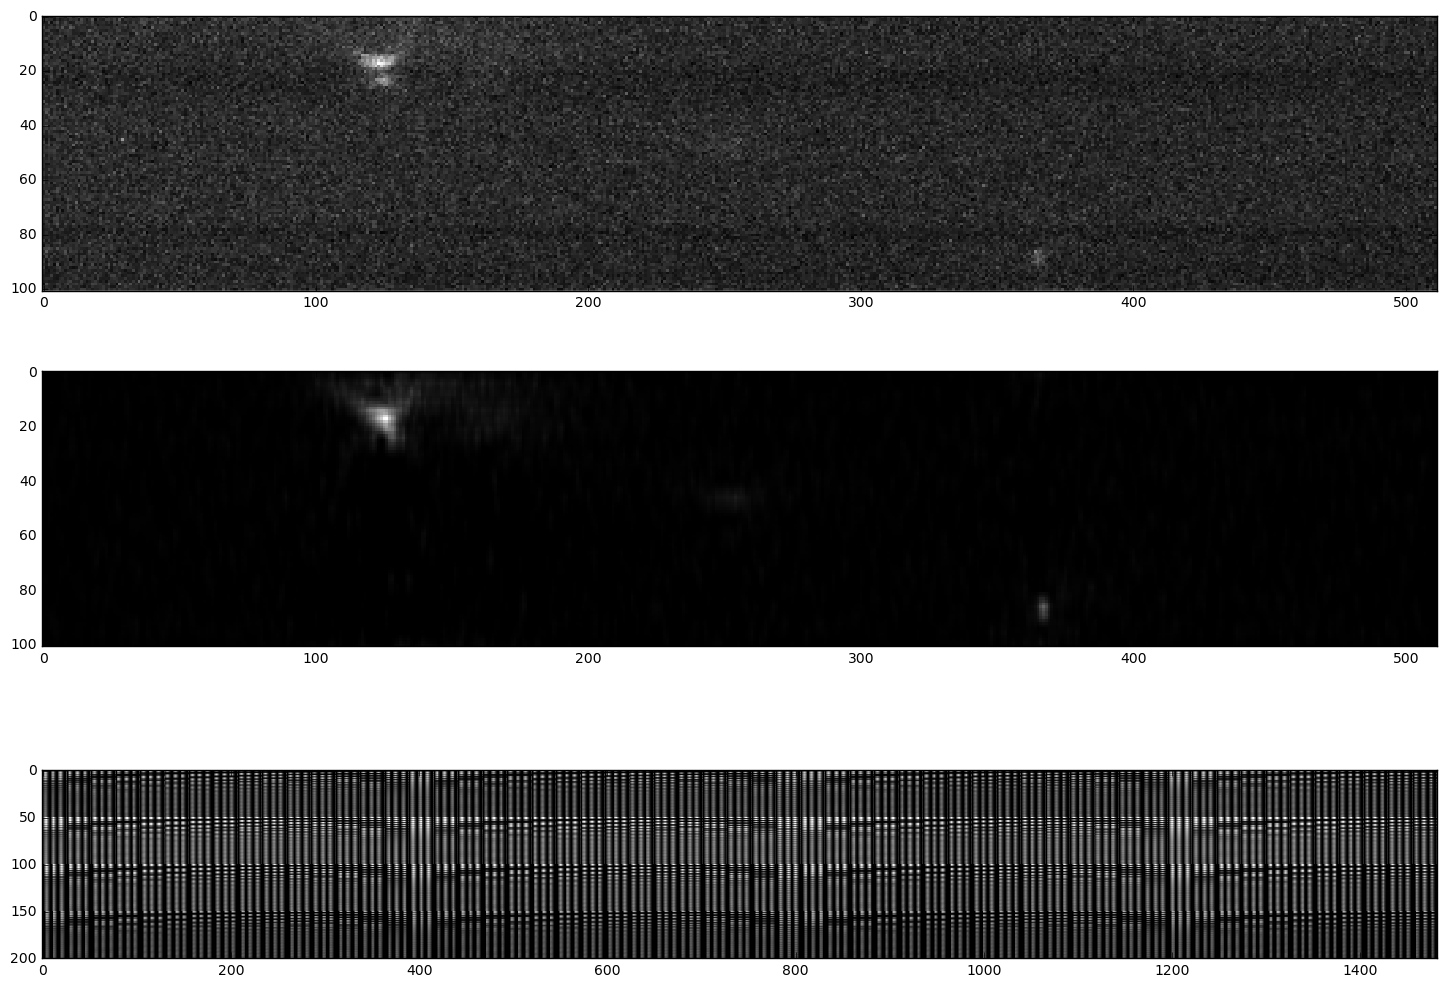

In [34]:
plt.figure(figsize=(18,13))
plt.subplot(311);plt.imshow(eye[205,:,:].T, cmap='gray', interpolation="none")
plt.subplot(312);plt.imshow(im, cmap='gray', interpolation="none")
plt.subplot(313);plt.imshow(B, cmap='gray', interpolation="none")

In [ ]:
## /!\ Be careful that this might take a lot of time
## Basically, this takes 512 times more time than the previous iteration
## /!\ ONCE AGAIN, 3'x512 = 1500' = ONE DAY
## A cluster version is provided below, consider it before doing weird things.

# Launch a full stack reconstruction
im3d = []
for i in range(fou.shape[0]):
    if i% 10 == 0:
        print "{}/{}".format(i,fou.shape[0])
    im = reco_image(fou[i,:,:], verbose=False)
    im3d.append(im)

In [ ]:
iff = TIFF.open("./img/paper3.beads_lattice_avg2D.tif", "w")
iff.write_image([(100*j).astype(np.uint16) for j in im3d])
iff.close()

# A cluster-ready version
## How to use it?

1. Copy the code in the appropriate directory (`../8_cluster/tars/07_reconstruction_3d/`)
2. Copy the data to the right paths
3. Log on `tars`

```{shell}
mkdir ../5_outputs/10_reconstructions_march_tars ## Create the output folder
module load Python/2.7.11

## Progressive test procedure
python ../8_cluster/tars/07_reconstruction_3d/reconstruction3.py 0 ## Simple test procedure
srun ~/.envs/dict-optim/bin/python ../8_cluster/tars/07_reconstruction_3d/reconstruction3.py 0 

```

4. Launch the real reconstructions: `./../8_cluster/tars/07_reconstruction_3d/reconstruction3.sh`
5. Recombine the images in a TIFF file: `python ../8_cluster/tars/07_reconstruction_3d/recombine.py rec ../5_outputs/10_reconstructions_march_tars/`

## The code

There is one critical parameter that was varied to generate Figure 3. This parameter is the number of measurements to take into account for the reconstruction: change the `n_mes` variable accordingly (was tuned from 2 to 50, corresponding to a compression/speedup of 2 to 50).

In [48]:
%%writefile ../../8_cluster/tars/07_reconstruction_3d/reconstruction3.sh
#!/bin/sh
## /!\ This code is generated by a Jupyter script, do not edit it directly.
## It is designed to run reconstructions on a very specific dataset.
## It should be adapted carefully before playing on the input stuff

echo "==== DISCLAIMER ===="
echo "Have you installed the following packages?: virtualenv, numpy, scipy libtiff, joblib, pycsalgos, h5py, pySPIRALTAP"
echo "Have you run the following commands to load the packages?"
echo "$ module load Python/2.7.11"
echo "$ source ~/.local/bin/virtualenvwrapper.sh"
echo "$ export WORKON_HOME=~/.envs"
echo "$ workon dict-optim"

N_FRAMES_IN_STACK=512
email="maxime.woringer@pasteur.fr"
maxparalleljobs=100

echo 'Running on tars'
sbatch --mail-type=BEGIN,END --mail-user=$email --array=0-$N_FRAMES_IN_STACK%$maxparalleljobs ../8_cluster/tars/07_reconstruction_3d/reconstruction3_init.sh

Overwriting ../../8_cluster/tars/07_reconstruction_3d/reconstruction3.sh


In [55]:
%%writefile ../../8_cluster/tars/07_reconstruction_3d/reconstruction3_init.sh
#!/bin/sh
#SBATCH --qos=fast 
#SBATCH -N 1
#SBATCH -c 12
#SBATCH -p common,dedicated
#SBATCH -o ../8_cluster/tars/06_reconstruct_3d/log_reconstruction.log -e ../8_cluster/tars/06_reconstruct_3d/log_reconstruction.err
# By Maxime W., Nov. 2016, GPLv3+
# /!\ DO NOT EDIT THIS FILE. IT HAS BEEN GENERATED BY A SCRIPT
# Script is ../2_simulations/51. ...ipynb

## This script to be called by SBATCH, do not call it directly, it will not work.
srun ~/.envs/dict-optim/bin/python ../8_cluster/tars/07_reconstruction_3d/reconstruction3.py ${SLURM_ARRAY_TASK_ID}

Overwriting ../../8_cluster/tars/07_reconstruction_3d/reconstruction3_init.sh


In [58]:
%%writefile ../../8_cluster/tars/07_reconstruction_3d/reconstruction3.py

import sys, os
import scipy.linalg
import numpy as np
from libtiff import TIFF
sys.path.append("../3_code/")
import cstools
#reload(cstools)

n_mes = 30 ## Compression factor (a number of frames)
save_prefix = "rec{}".format(n_mes)


## tars-specific parameters
frame_to_reconstruct = int(sys.argv[1])


# useful function
def spiral(m, b):
    return cstools.reconstruct_1Dspiral(m, b, maxiter=1000, noisetype='poisson')
def spiral2(m, b):
    return cstools.reconstruct_1Dspiral(m, b, maxiter=2000)

bn = "../4_data/lattice-lightsheet/161013_cstest/"
eye_p = os.path.join(bn, "eyefullfov20um.tif")
fou_p = os.path.join(bn, "fourierfullfov20um.tif")

out_folder = "../5_outputs/10_reconstructions_march_tars"

## Do not reconstruct if we already have it
if os.path.exists(os.path.join(out_folder, "{}.{}.txt".format(save_prefix, frame_to_reconstruct))):
    print "reconstruction {} exists, aborting".format("{}.{}.txt".format(save_prefix, frame_to_reconstruct))
    sys.exit(0)

# Load matrices
fou = cstools.read_tif(fou_p, div2=True)
eye = cstools.read_tif(eye_p, div2=True)

###
### ========================================
###

## 1. Extract a PSF
psfz_ok = True # Flag to switch between calibration and generation of the PSF
psfx_ok = True
save_psf = "../5_outputs/psf_models/lattice_161114" ## Set to None to avoid saving
load_psf = True ## Load the PSF from the save_psf file.

step = 8 ## A fraction of the size of the PSF in z. Represent the shift in the final dictionary.
psf_x = 205
psf_y = range(363, 367)
psf_z = (82, 95)

if load_psf:
    psf=np.load(save_psf+".npy")
    print "Loaded PSF from file {}.npy".format(save_psf)
else:
    psf = eye.mean(0)[psf_y,psf_z[0]:psf_z[-1]].T
    psf -= psf.min()

if save_psf != None and not load_psf and not os.path.isfile(save_psf): ## Save the PSF if needed
    np.save(save_psf, psf)
    print "PSF saved on file {}".format(save_psf)
elif not load_psf and save_psf != None and os.path.isfile(save_psf):
    raise IOError("File {} exists".format(save_psf))
else:
    print "Not saving the PSF"

if not psfz_ok:
    plt.imshow(psf, cmap='gray', interpolation="none")
elif not psfx_ok:
    psf_xutil = psf.mean(1)
    plt.plot(psf_xutil)
else:
    l=np.zeros((eye.shape[2], 2*psf.shape[1]))
    l[:psf.shape[0],:psf.shape[1]]=psf
    ll=[]
    for j in range(step*int(eye.shape[2]/psf.shape[0])+1):
        for k in range(2*psf.shape[0]):
            ll.append(np.roll(np.roll(l, psf.shape[0]*psf.shape[1]*j/step, axis=0), k, axis=1)[:,int(l.shape[1]/2):int(l.shape[1]*3./2)])
    
    D1 = np.hstack(ll) ## This is the dictionary.
    D2 = np.hstack([i.T.reshape((-1,1)) for i in ll])
    
###
### ======================== Generate stuff
###

## Generate measurement matrix
# Generate basis
if n_mes == 0:
    b=cstools.generate_fourier_basis(101, 50+1, sample=False, oldmethod=True)
else:
    print "Truncating"
    b=cstools.generate_fourier_basis(101, n_mes+1, sample=False, oldmethod=True)
    fou = fou[:,:,:n_mes]

B = cstools.build_2dmodel(b, psf.mean(0)).dot(D2)

## Apply the 2D model
def reco_image(ima, verbose=True, tv=False):
    rr1 = np.arange(0, eye[0, :,:].shape[0]-psf.shape[1], 1)
    rr2 = rr1 + psf.shape[1]
    im = np.zeros_like(eye[0,:,:].T)
    for (i,j) in enumerate(zip(rr1,rr2)):
        if verbose and i%100 == 0:
            print "{}/{}".format(i, len(rr1))
        (sta,sto) = j
        #im_sub = fou[ima, range(sta,sto),:].flatten()
        im_sub = ima[range(sta,sto),:].flatten()
        if tv:
            r_sim = spiral_tv(im_sub, B).dot(D2.T).reshape((psf.shape[1], -1))
        else:
            r_sim = spiral2(im_sub, B).dot(D2.T).reshape((psf.shape[1], -1))
        #im.append(r_sim)
        im[:,sta:sto]+=r_sim.T
    #im = np.vstack(im).T
    #im = np.zeros(())
    return im

###
### =========================== Reconstruction step
###
print "Reconstructing"
im = reco_image(fou[frame_to_reconstruct,:,:], verbose=False) # Launch a full stack reconstruction

###
### =========================== Saving step
###
np.savetxt(os.path.join(out_folder, "{}.{}.txt".format(save_prefix, frame_to_reconstruct)), im)

Overwriting ../../8_cluster/tars/07_reconstruction_3d/reconstruction3.py


# Recombine the .txt file in one .tiff file

Note that the dimensions of the output images are hardcoded (look at `dim1` and `dim2` variables). You might have to transpose the output if your reconstructions are along the wrong dimension)

In [59]:
%%writefile ../../8_cluster/tars/07_reconstruction_3d/recombine.py
## Maxime W., Jul 2016, GPLv3+
## This is actually the worker to combine the movie to a 3D stack

# ==== Imports
import sys, os
import numpy as np
from libtiff import TIFF

dim1 = 512
dim2 = 101
scl = 500 # Multiply by this factor before saving.


print "Saving a stack of {} elements, {} px".format(dim2, dim1)

# ==== Variables
(none, frame_bn, out_dir) = sys.argv
tmp_dir = os.path.join(out_dir, '')
out_file = os.path.join(out_dir, "{}.tif".format(frame_bn))
remove_neg = True # if True, negative elements in the reconstruction will be set to zero.

# ==== Checking inputs
## Input files
inp_files = [i for i in os.listdir(tmp_dir) if i.startswith(frame_bn)]
if inp_files == []:
    raise IOError('No files found in {} with name starting with {}. ABORTING'.format(tmp_dir, frame_bn))
    
## Output file
if os.path.isfile(out_file):
    im = TIFF.open(out_file, 'r')
    for i in im.iter_images():
        frame0=i
        break
    im.close()
    if frame0.shape[0] >= len(inp_files):
        print "A TIFF stack already exists and has at least as many pixels as what we"
        print "were aiming to reconstruct. EXITING."
        sys.exit(0)

## ==== Saving image
print('Image dimensions are hardcoded so far. I know this is stupid.')
idx = [int(i.split('.')[-2]) for i in inp_files]
lf = sorted(zip(inp_files, idx), key=lambda x: x[1])
im = np.zeros((len(lf), dim1, dim2))
for (i,j) in enumerate(lf):
    f=np.genfromtxt(os.path.join(tmp_dir, j[0]))
    im[i,:,:]=f.T
print "Loaded {} planes".format(len(lf))

if remove_neg:
    print "Negative elements were set to zero"
    im[im<0]=0 ## Bruteforce.
tif = TIFF.open(out_file, 'w')
tif.write_image(np.array(np.int_(im*scl).swapaxes(2, 0).swapaxes(1,2), dtype=np.uint16))
tif.close()

Overwriting ../../8_cluster/tars/07_reconstruction_3d/recombine.py
